# Flir Tau2 Temperature Calibration
The common functionality of every thermal camera is to provide a pixel-wise temperature estimation of the scene.
This notebook will explore the relationship between the raw grey levels and the temperature of the scene.

To that end, a black-body is being captured by the camera at fixed (known) temperature levels. the grey levels obtained at each temperature are then used, together with the known temperatures, to construct a regression model for estimating the temperature given the grey-level

## Packages and data imports:

In [5]:
from tools import get_measurements, FilterWavelength, FilterWavelength, find_parent_dir
from tools import c2k, k2c
import numpy as np
from models.colorization import GlRegressor
import sys
from pathlib import Path
sys.path.append(str(Path().cwd().parent))

import matplotlib
from plots import showFacetImages
%load_ext autoreload
%autoreload 2
%matplotlib widget

matplotlib.rcParams.update({'font.size': 14})

path_to_files = find_parent_dir("rawData") / 'calib' / 'tlinear_0'
path_to_models = find_parent_dir("models")

meas_panchromatic, _, _, _, list_blackbody_temperatures, _ =\
    get_measurements(path_to_files, filter_wavelength=FilterWavelength.PAN, fast_load=True, do_prefilt=False)


list_blackbody_temperatures = np.asarray(list_blackbody_temperatures)
gl_regressor = GlRegressor(is_parallel=True, x_label="T")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


calculating power: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


In [6]:
## Auxiliary functions:
def get_regression(re_run_regression, deg=1, feature_power=1, model_name=""):
    f_name = model_name + ".pkl"
    if re_run_regression:
        gl_regressor.fit(c2k(list_blackbody_temperatures),
                         meas_panchromatic, deg=deg, feature_power=feature_power, debug=True)
        gl_regressor.save_model(path_to_models / f_name)
    else:
        gl_regressor.load_model(path_to_models / f_name)


def eval_fit():

    # eval fit:
    gl_hat = gl_regressor.predict(c2k(list_blackbody_temperatures))
    ax_lbls = {"xlabel": "Temperature[C]", "ylabel": "Grey-levels"}
    err_df = gl_regressor.eval(meas_panchromatic, gl_hat,
                               list_blackbody_temperatures, debug=True, ax_lbls=ax_lbls)

    # eval inverse fit:
    t_hat = k2c(gl_regressor.predict(meas_panchromatic, is_inverse=True))
    ax_lbls = {"xlabel": "BB Temperature[C]", "ylabel": "T[C]"}
    err_df = gl_regressor.eval(list_blackbody_temperatures, t_hat,
                               list_blackbody_temperatures, debug=True, ax_lbls=ax_lbls)



## Linear Fit
First, we assume a linear model between temperature and grey-level, and perform a linear regression.
$$GL = \hat{\text{intercept}} \times T +\hat{\text{slope}}$$

*Remark*: For the regression parameters estimation, we use only every 2nd measurement in order to avoid overfitting, and use the dropped-out measurements as a validation set.


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:30<00:00, 947.25it/s]


Regression is complete!


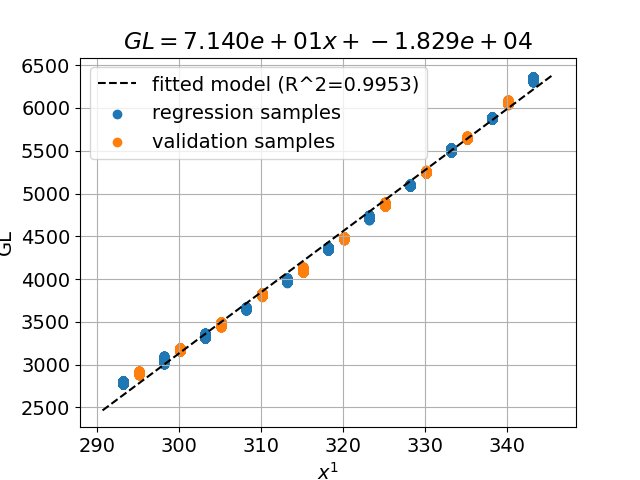

In [7]:
get_regression(re_run_regression=True, model_name="t2gl_1ord")

We are also interested in estimating the temperature, based on the acquired grey-levels (the inverse model):
$$ \hat{GL} = slope \times T + \text{intercept} \Rightarrow \hat{T} = \frac{GL - \text{intercept}}{\text{slope}} $$


Predicting: 100%|██████████| 86016/86016 [00:01<00:00, 79940.06it/s] 


Predictions are ready!


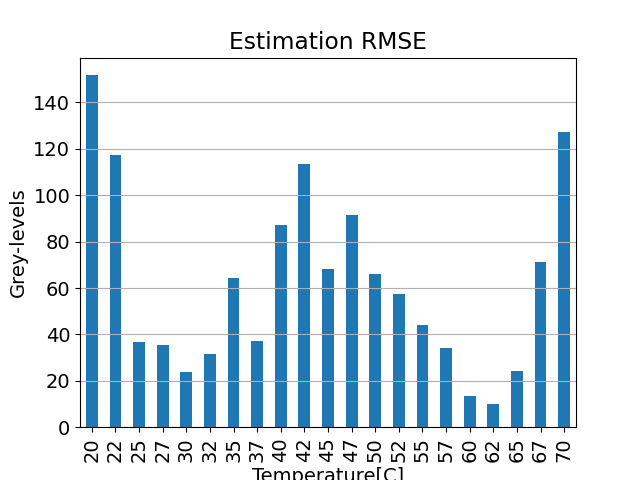

Predicting: 100%|██████████| 86016/86016 [11:26<00:00, 125.28it/s]


Predictions are ready!


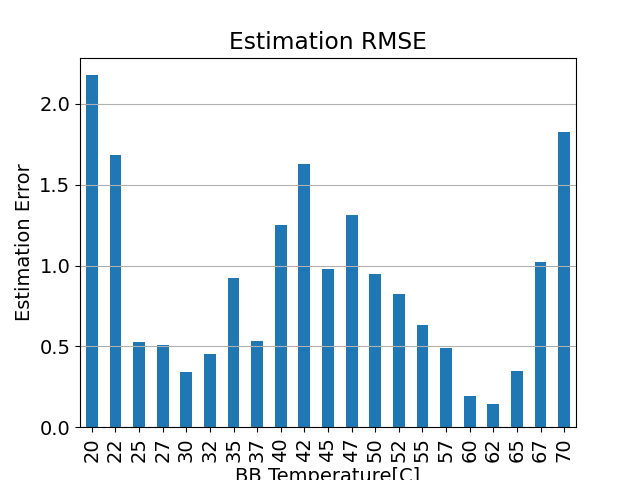

In [8]:
eval_fit()

A few observations can be made based on the obtained statistics:
1. The linear model isn't a very good estimate for many operating points, with an RMSE of > 2C in the worst case, and >1C for more than half the operating points.
2. The standard-deviation of all operating points is incredibely small, suggesting that the error trend is very similar for all pixels

These observations give hope that a better model(perhaps a higher degree polynomial) will result in a better fit for all pixels.

Regardless of the suggested models, a proper evaluation should be based on a validation set of measurements that weren't used for constructing the model.


## Quadratic Fit
Following the observations of the linear-regression, it appears that the linear model is underfit for the data at hand. Hence, we'll try to fit a 2nd order (quadratic) polynomial model and test it's performance:


Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:41<00:00, 848.22it/s]


Regression is complete!


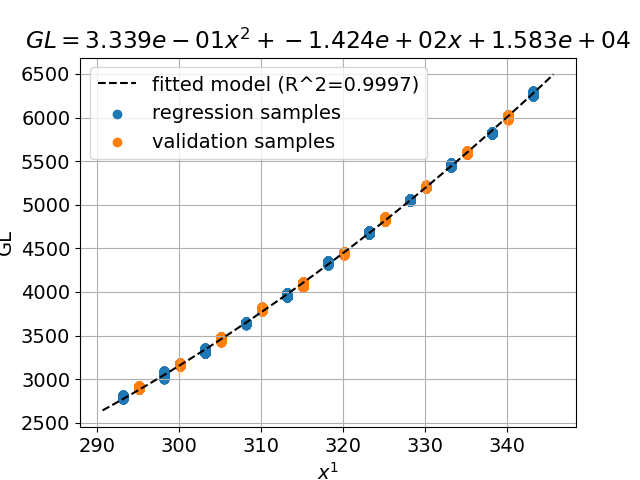

In [9]:
get_regression(re_run_regression=True, model_name="t2gl_2ord", deg=2)

In the quadratic fit case, there isn't a unique solution for the inverse model (mathematically there are 2 solutions). However, as all temperatures used for the regression are positive and as the fit's derivative in the region of interest is positive - we know that the correct solution is the greater one, allowing us to solve for T.

Predicting: 100%|██████████| 86016/86016 [00:01<00:00, 74921.38it/s] 


Predictions are ready!


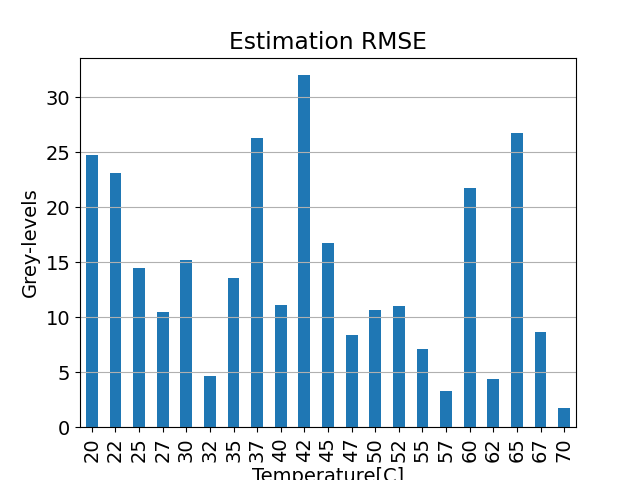

Predicting: 100%|██████████| 86016/86016 [06:24<00:00, 223.91it/s]


Predictions are ready!


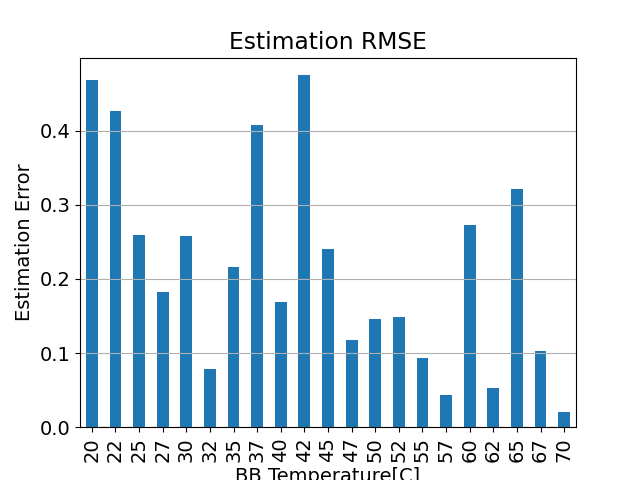

In [10]:
eval_fit()

## Physical Model
While both the quadratic model provides a much better approximation than the linear one, there is no physical justification for the correctness of this model. 

According to Plank's law, the spectral radiance density is (expressed in units of frequency rather than wavelength):
$$ \mathcal{B}_\nu(T) = \frac{2h\nu^3}{c^2} \frac{1}{e^{h\nu/kT}-1} $$

Assuming an optimal sensor (constant transfer function of 0dB gain for all frequencies), Stefan-Boltzmann law suggests that the radiance $L$ obtained by integrating $\mathcal{B}_\nu(T)$ over the entire spectrum of frequencies is proportional to the 4th power of the temperature:

$$ \int_{\nu} \mathcal{B}_\nu(T) d\nu = \frac{\sigma}{\pi}T^4 $$

Where $\sigma \approx 5.67 \times 10^{-8} \frac{W}{m^2K^4}$ is the Stefan-Boltzmann constant.

Even if our sensor's spectral response isn't optimal, as long as it's temperature invariant (temperature being the black-body's temperature, not the housing temperature) - the proportionality to the temperature should remain the same. See the justification under the Stefan–Boltzmann law section under wikipedia's black-body radiation article.

Pre-Processing Variables For Regression...
Pre-Processing is Complete!
Performing the regression (this might take a few seconds/minutes, depending on the data size...)


Performing Regression: 100%|██████████| 86016/86016 [01:18<00:00, 1098.72it/s]


Regression is complete!


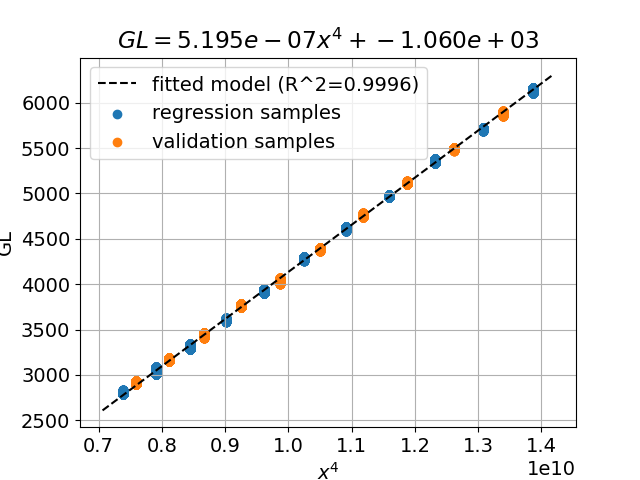

In [11]:
get_regression(re_run_regression=True, model_name="t2gl_4ord", feature_power=4)

Predicting: 100%|██████████| 86016/86016 [00:01<00:00, 77501.22it/s] 


Predictions are ready!


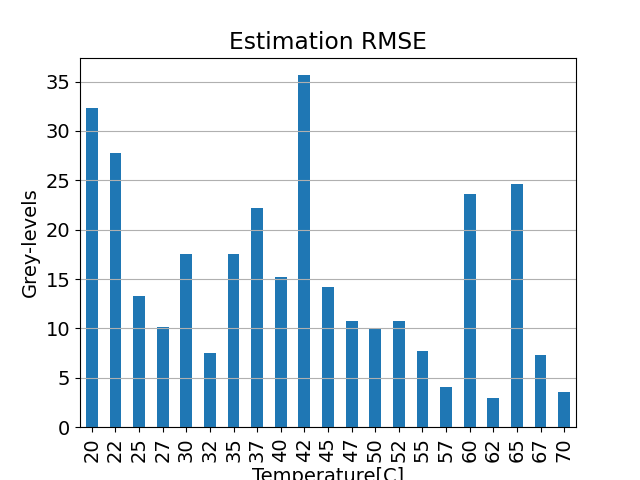

Predicting: 100%|██████████| 86016/86016 [08:00<00:00, 179.09it/s]


Predictions are ready!


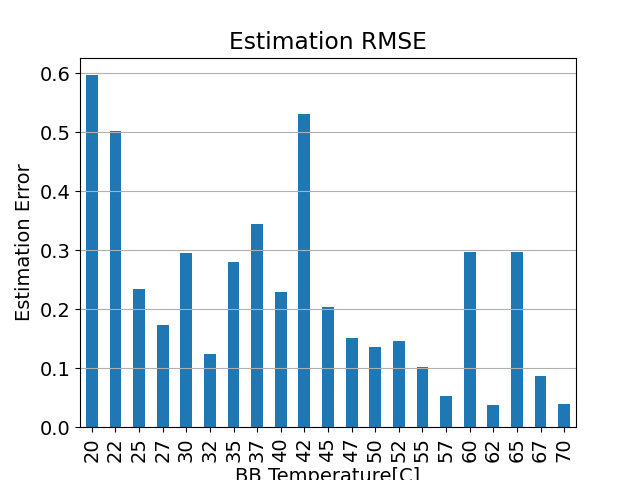

In [12]:
eval_fit()

It appears that both the quadratic model in $T$ and the linear model in $T^4$ provide satisfactory results in terms of temperature estimation, as the worst case RMSE in both cases is in a subdegrees.

While the quadratic model seems to perform marginally better, the linear model in $T^4$ is physically justified, and is hence expected to better generalize to unseen measurements. 